# Generate fun images of your dog

***
In this demo notebook, we demonstrate how to use the JumpStart APIs to fine-tune the stable diffusion model to your dog images dataset and deploy the fine-tuned model. To execute this notebook, you will need a collection of dog images. You may upload as little as five images. 

Note: This notebook contains a very simplified version of the features available for Stable Diffusion in JumpStart. Please refer to the [notebook](https://github.com/aws/amazon-sagemaker-examples/tree/main/introduction_to_amazon_algorithms/jumpstart_text_to_image) for a more comprehensive list of Stable Diffusion features available in JumpStart. 

***

1. [Set Up](#1.-Set-Up)

3. [Fine-tune the pre-trained model on a custom dataset](#3.-Fine-tune-the-pre-trained-model-on-a-custom-dataset)
    * [Retrieve Training Artifacts](#3.1.-Retrieve-Training-Artifacts)
    * [Set Training parameters](#3.2.-Set-Training-parameters)
    * [Start Training](#3.3.-Start-Training)
    * [Deploy and run inference on the fine-tuned model](#3.4.-Deploy-and-run-inference-on-the-fine-tuned-model)


## 1. Set Up

In [2]:
import botocore
import sagemaker, boto3, json
from sagemaker import get_execution_role
import os


aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

# If uploading to a different folder, change this variable.
local_training_dataset_folder = "training_images"
if not os.path.exists(local_training_dataset_folder):
    os.mkdir(local_training_dataset_folder)

***

### Please upload images of your dog to `training_images` local folder and change use_local_images=True.

***

In [3]:
use_local_images = True # This will use the example dataset provided by 


if not use_local_images:
    #Downloading example dog images from JumpStart S3 bucket
    
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(f"jumpstart-cache-prod-{aws_region}") 
    for obj in bucket.objects.filter(Prefix = "training-datasets/dogs_sd_finetuning/"):
        bucket.download_file(obj.key, os.path.join(local_training_dataset_folder,obj.key.split('/')[-1])) # save to same path

In [4]:
# Instance prompt refers to the textual description of images in the training dataset. Try to be as detailed as as accurate as possible.
# In addition to the textual description, we also need a tag (sks in the example below). 

instance_prompt = "A photo of my dog Finn"

In [5]:
# Instance prompt is fed into the training script via dataset_info.json present in the training folder. Here, we write that file.
import os
import json

with open(os.path.join(local_training_dataset_folder, 'dataset_info.json'),'w') as f:
    f.write(json.dumps({"instance_prompt":instance_prompt}))

### Upload dataset to S3

***
Next, we upload the dataset to S3 bucket. If the bucket does not exists, we create a new bucket. 

***

In [6]:
mySession = boto3.session.Session()
AwsRegion = mySession.region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

training_bucket = f"stable-diffusion-jumpstart-{AwsRegion}-{account_id}"

***

If you have an existing bucket you would like to use, please replace the `training_bucket` with your bucket in the cell above and avoid executing the following cell.

***

In [ ]:
def create_bucket_if_not_exists(training_bucket):
    import boto3
    import botocore

    mySession = boto3.session.Session()
    AwsRegion = mySession.region_name



    s3_rsrc = boto3.resource('s3')

    try:
        s3_rsrc.meta.client.head_bucket(Bucket=training_bucket)
        print(f'Using an existing bucket {training_bucket}')
    except botocore.exceptions.ClientError as e:
        if e.response.get('Error') is not None and e.response['Error'].get('Code') is not None and e.response['Error'][
            'Code'] == '404':
            try:
                if AwsRegion == 'us-east-1':
                    s3_bucket = s3_rsrc.create_bucket(Bucket=training_bucket)
                    print(f'Created {s3_bucket}')
                else:
                    s3_bucket = s3_rsrc.create_bucket(Bucket=training_bucket,
                                                      CreateBucketConfiguration={'LocationConstraint': AwsRegion})
                    print(f'Created {s3_bucket}')
            except Exception as e:
                raise Exception(f'Error Creating S3 bucket {training_bucket}.\n' + str(e))
        else:
            raise Exception(f'Error checking if the bucket {training_bucket} exists or not.\n' + str(e))
    except Exception as e:
        raise Exception(f'Error checking if the bucket {training_bucket} exists or not. \n' + str(e))


In [7]:
assets_bucket = f'jumpstart-cache-prod-{AwsRegion}'


s3 = boto3.client('s3')
s3.download_file(f'jumpstart-cache-prod-{AwsRegion}', 'ai_services_assets/custom_labels/cl_jumpstart_ic_notebook_utils.py', 'utils.py')




Using an existing bucket stable-diffusion-jumpstart-us-east-1-079002598131


***

Next we upload the training datasets (images and `dataset_info.json`) to the S3 bucket.

***


In [8]:
!ls $local_training_dataset_folder

IMG_0063.jpg  IMG_1033.jpg  IMG_1057.jpg  IMG_2824.jpg	dataset_info.json
IMG_0068.jpg  IMG_1054.jpg  IMG_2329.jpg  IMG_8226.jpg


In [9]:
train_s3_path = f"s3://{training_bucket}/custom_dog_stable_diffusion_dataset/"

!aws s3 cp --recursive $local_training_dataset_folder $train_s3_path

upload: training_images/.ipynb_checkpoints/dataset_info-checkpoint.json to s3://stable-diffusion-jumpstart-us-east-1-079002598131/custom_dog_stable_diffusion_dataset/.ipynb_checkpoints/dataset_info-checkpoint.json
upload: training_images/.ipynb_checkpoints/IMG_8226-checkpoint.jpg to s3://stable-diffusion-jumpstart-us-east-1-079002598131/custom_dog_stable_diffusion_dataset/.ipynb_checkpoints/IMG_8226-checkpoint.jpg
upload: training_images/.ipynb_checkpoints/IMG_0068-checkpoint.jpg to s3://stable-diffusion-jumpstart-us-east-1-079002598131/custom_dog_stable_diffusion_dataset/.ipynb_checkpoints/IMG_0068-checkpoint.jpg
upload: training_images/.ipynb_checkpoints/IMG_1033-checkpoint.jpg to s3://stable-diffusion-jumpstart-us-east-1-079002598131/custom_dog_stable_diffusion_dataset/.ipynb_checkpoints/IMG_1033-checkpoint.jpg
upload: training_images/.ipynb_checkpoints/IMG_2824-checkpoint.jpg to s3://stable-diffusion-jumpstart-us-east-1-079002598131/custom_dog_stable_diffusion_dataset/.ipynb_checkp

## 2. Fine-tune the pre-trained model on a custom dataset



### 2.1. Retrieve Training Artifacts

---
Here, we retrieve the training docker container, the training algorithm source, and the pre-trained base model. Note that model_version="*" fetches the latest model.

---

In [10]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = (
    "model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    "*",
    "training",
)

# Tested with ml.g4dn.2xlarge (16GB GPU memory) and ml.g5.2xlarge (24GB GPU memory) instances. Other instances may work as well.
# If ml.g5.2xlarge instance type is available, please change the following instance type to speed up training.
training_instance_type = "ml.g4dn.2xlarge" # $0.75 per hour as of feb 2023

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,     # automatically inferred from model_id
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)

# Retrieve the training script. This contains all the necessary files including data processing, model training etc.
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

### 2.2. Set Training parameters

***
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include: (i) Training data path: This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training. We defined the training instance type above to fetch the correct `train_image_uri`.

The second set of parameters are algorithm specific training hyper-parameters.
***

In [11]:
output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-sd-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

***
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.
***

In [12]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values. This controls the duration of the training and the quality of the output. 
# If max_steps is too small, training will be fast but the the model will not be able to generate custom images for your usecase.
# If max_steps is too large, training will be very slow.
hyperparameters["max_steps"] = "200"
print(hyperparameters)

{'epochs': '20', 'max_steps': '200', 'batch_size': '1', 'with_prior_preservation': 'False', 'num_class_images': '100', 'learning_rate': '2e-06', 'prior_loss_weight': '1.0', 'center_crop': 'False', 'lr_scheduler': 'constant', 'adam_weight_decay': '0.01', 'adam_beta1': '0.9', 'adam_beta2': '0.999', 'adam_epsilon': '1e-08', 'gradient_accumulation_steps': '1', 'max_grad_norm': '1.0', 'seed': '0'}


### 2.3. Start Training
---
We start by creating the estimator object with all the required assets and then launch the training job.  It takes less than 10 mins on the default dataset.

---

In [13]:
%time
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"jumpstart-example-{train_model_id}-transfer-learning")

# Create SageMaker Estimator instance
sd_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",  # Entry-point file in source_dir and present in train_source_uri.
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
)

# Launch a SageMaker Training job by passing s3 path of the training data
sd_estimator.fit({"training": train_s3_path}, logs=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


INFO:sagemaker:Creating training-job with name: jumpstart-example-model-txt2img-stabili-2023-02-23-12-54-08-078


2023-02-23 12:54:08 Starting - Starting the training job...
2023-02-23 12:54:24 Starting - Preparing the instances for training......
2023-02-23 12:55:23 Downloading - Downloading input data...............
2023-02-23 12:58:04 Training - Downloading the training image.........
2023-02-23 12:59:15 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-23 12:59:41,841 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-23 12:59:41,867 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-23 12:59:41,870 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-02-23 12:59:42,857 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python3.8 -m pip install -r requirements.txt
Processing ./lib/accelerat

### 2.4. Deploy and run inference on the fine-tuned model

---

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the bounding boxes of an image. We start by retrieving the JumpStart artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `sd_estimator` that we have fine-tuned.

---

In [14]:
from sagemaker import image_uris, model_uris, script_uris
from sagemaker.utils import name_from_base


inference_instance_type = "ml.g4dn.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None, 
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-FT-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = sd_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-02-23-13-16-07-280
INFO:sagemaker:Creating endpoint-config with name jumpstart-example-FT-model-txt2img-stab-2023-02-23-13-16-07-280
INFO:sagemaker:Creating endpoint with name jumpstart-example-FT-model-txt2img-stab-2023-02-23-13-16-07-280


--------!

In [15]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = json.dumps(text).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

## Original images of Finn

![](training_images/finn3.jpg)
![](training_images/finn4.jpg)
![](training_images/finn5.jpg)
![](training_images/finn6.jpg)

Next, we query the finetuned model, parse the response and display the generated image.  Please execute the following cells.

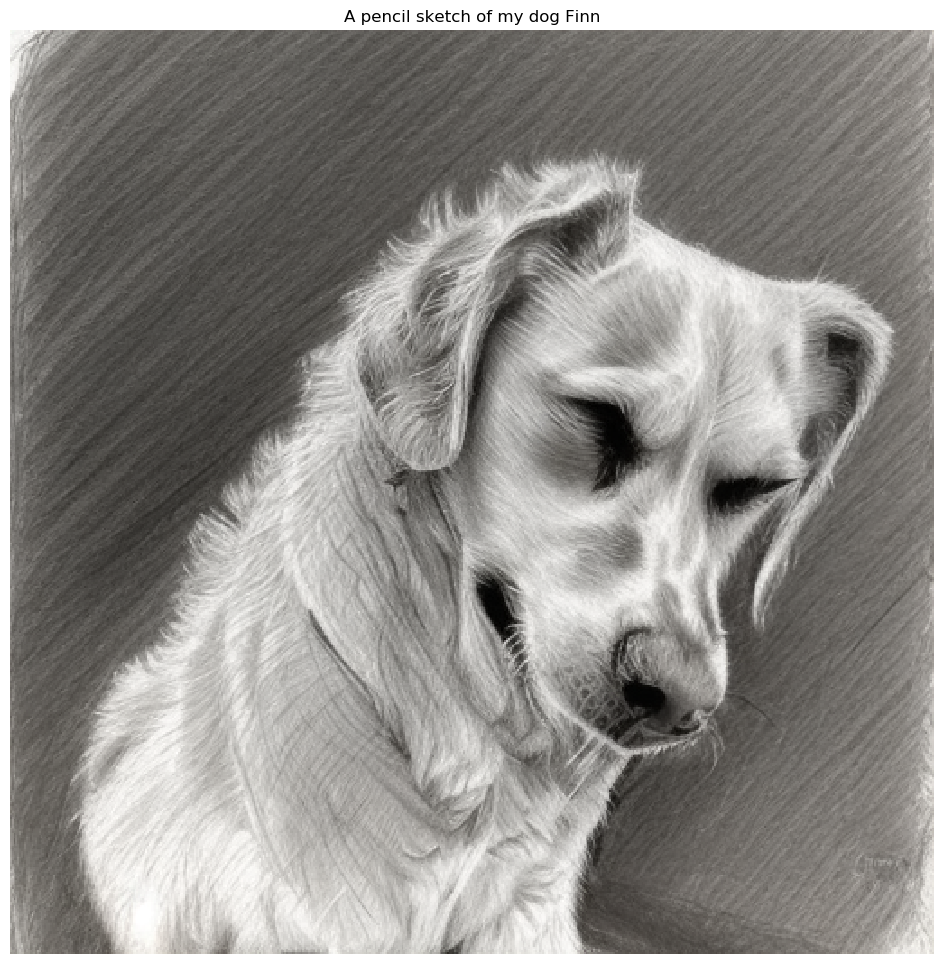

In [16]:
all_prompts = ["A pencil sketch of my dog Finn"]
for prompt in all_prompts:

    query_response = query(finetuned_predictor, prompt)
    img, _ = parse_response(query_response)
    display_img_and_prompt(img, prompt)

In [21]:
# all_prompts = ["A pencil sketch of my dog Finn", "A photo of my dog, Finn, playing football", "A photo of my dog, Finn, in a suit", "A photo of my dog, Finn, with a hat"]
# for prompt in all_prompts:

#     query_response = query(finetuned_predictor, prompt)
#     img, _ = parse_response(query_response)
#     display_img_and_prompt(img, prompt)

---
Next, we delete the endpoint corresponding to the finetuned model.

---

In [17]:
# # Delete the SageMaker endpoint
# finetuned_predictor.delete_model()
# finetuned_predictor.delete_endpoint()

## Conclusion
***
In this notebook, we saw how you can fine-tune the stable diffusion text-to-image model on your dataset with a small set of images. 


***